In [ ]:
#importing necessary libraries 
import pandas as pd
import nltk
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim.parsing.preprocessing import STOPWORDS
import numpy as np
import pickle
nltk.download('stopwords')
nltk.download('wordnet')
from typing import List, Dict, Tuple, Set
import itertools
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import requests
import json
import urllib.request
import time
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import re
from sklearn.metrics.pairwise import cosine_similarity
import statistics
from datetime import datetime
from scipy.stats import skew
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading dataset

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
train_firefox_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_train_preprocessed.csv')
train_firefox_df


,Unnamed: 0,description1,description2,is_similar
0,0,created attachment fandango com after sign...,user agent mozilla gecko firefox ...,0
1,1,created attachment dropdown marker ...,user agent mozilla gecko firefox ...,1
2,3,this bug was initially created as a clon...,note i am very bad at filing bugs so i apo...,0
3,4,currently in policies we have two function ...,filed by ncsoregi at mozilla com pa...,0
4,5,remove bottom margin on image wrapper for ...,there s only a few tests remaining in browse...,0
...,...,...,...,...
31606,32441,the default light and dark themes should be...,this is happening because we have some code ...,0
31607,32442,filed by nbeleuzu at mozilla com pa...,filed by malexandru at mozilla com ...,1
31608,32443,created attachment first login is not sele...,created attachment screenshot my nightly ...,0
31609,32444,created attachment docx user agent moz...,created attachment docx user agent moz...,1


In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
test_firefox_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_test_preprocessed.csv')
test_firefox_df

,Unnamed: 0,description1,description2,is_similar
0,0,the comment in the code suggests it can be r...,bug is adding a new pinned page action o...,0
1,1,created attachment jira sidbar png user a...,automatically unloading a webrtc tab seems l...,0
2,2,created attachment reference png hi th...,filed by philringnalda at gmail com j...,0
3,3,markdown filed by rmaries at mozilla ...,user agent mozilla gecko firefox ...,0
4,4,user agent mozilla gecko firefox ...,currently we are storing full details in t...,0
...,...,...,...,...
8162,8392,filed by egao at mozilla com parsed...,scope of this bug is to investigate and impl...,0
8163,8393,filed by malexandru at mozilla com ...,steps to reproduce open several firefo...,0
8164,8394,sanitizer jsm is intended to become our inte...,considering the impact on privacy we should...,1
8165,8395,created attachment png user agent mozi...,user agent mozilla gecko firefox ...,0


In [ ]:
#Merge train & test
frames = [train_firefox_df, test_firefox_df]
result = pd.concat(frames)
result = result.sample(frac=1, random_state=1).reset_index(drop=True)
result1 = result.copy()
dup_df= result.copy()
dup_df

,Unnamed: 0,description1,description2,is_similar
0,22206,a collection of bugs that were considered ni...,filed by mlaza at mozilla com parse...,0
1,14075,created attachment screenshot of the issue...,user agent mozilla gecko firefox ...,0
2,4147,some websites will create an extra history i...,the intent of this bug is to block the histo...,1
3,24561,with bug we are have now shipped shield r...,str open the application menu clos...,0
4,12529,created attachment firefox dos mkv disc...,currently we empty the last etag central r...,0
...,...,...,...,...
39773,8023,created attachment screen shot steps to...,created attachment this video demonstrates...,0
39774,913,after bug disabling it landed and having t...,as we have landed bug there is no longer ...,1
39775,5334,user agent mozilla gecko firefox ...,markdown filed by csabou at mozilla c...,0
39776,12490,user agent mozilla gecko firefox ...,talos has detected a firefox performance reg...,0


In [ ]:
FEATURES = ['description1', 'description2']
print('Description of length of the feature columns')
dup_df[FEATURES].apply(lambda col: col.str.len().describe())

Description of length of the feature columns


,description1,description2
count,39778.000000,39778.000000
mean,1111.995324,1185.271406
std,2859.586179,3082.720871
min,50.000000,50.000000
25%,281.000000,289.000000
50%,482.000000,510.000000
75%,841.000000,925.000000
max,67448.000000,67448.000000


## Train, Validation, Test Split

In [ ]:
from sklearn.model_selection import train_test_split
import random
import sklearn

In [ ]:
train_val_df = train_firefox_df.copy()
train_val_df

,Unnamed: 0,description1,description2,is_similar
0,0,created attachment fandango com after sign...,user agent mozilla gecko firefox ...,0
1,1,created attachment dropdown marker ...,user agent mozilla gecko firefox ...,1
2,3,this bug was initially created as a clon...,note i am very bad at filing bugs so i apo...,0
3,4,currently in policies we have two function ...,filed by ncsoregi at mozilla com pa...,0
4,5,remove bottom margin on image wrapper for ...,there s only a few tests remaining in browse...,0
...,...,...,...,...
31606,32441,the default light and dark themes should be...,this is happening because we have some code ...,0
31607,32442,filed by nbeleuzu at mozilla com pa...,filed by malexandru at mozilla com ...,1
31608,32443,created attachment first login is not sele...,created attachment screenshot my nightly ...,0
31609,32444,created attachment docx user agent moz...,created attachment docx user agent moz...,1


In [ ]:
 test_df = test_firefox_df.copy()
 test_df

,Unnamed: 0,description1,description2,is_similar
0,0,the comment in the code suggests it can be r...,bug is adding a new pinned page action o...,0
1,1,created attachment jira sidbar png user a...,automatically unloading a webrtc tab seems l...,0
2,2,created attachment reference png hi th...,filed by philringnalda at gmail com j...,0
3,3,markdown filed by rmaries at mozilla ...,user agent mozilla gecko firefox ...,0
4,4,user agent mozilla gecko firefox ...,currently we are storing full details in t...,0
...,...,...,...,...
8162,8392,filed by egao at mozilla com parsed...,scope of this bug is to investigate and impl...,0
8163,8393,filed by malexandru at mozilla com ...,steps to reproduce open several firefo...,0
8164,8394,sanitizer jsm is intended to become our inte...,considering the impact on privacy we should...,1
8165,8395,created attachment png user agent mozi...,user agent mozilla gecko firefox ...,0


In [ ]:
train_df, val_df = train_test_split(
  train_val_df,
  test_size=0.2,
  stratify=train_val_df.is_similar,
  random_state=13,
)

In [ ]:
train_df

,Unnamed: 0,description1,description2,is_similar
20631,21175,filed by btara at mozilla com parse...,steps to reproduce set browser proton ...,0
23683,24304,created attachment how it works link add ...,firefox will not launch after recent auto up...,0
26636,27336,we want to detect browser pinned status in o...,created attachment superscia campania edit...,0
25053,25710,change line height of the sponsored by label...,i don t have solid steps to reproduce yet h...,0
28671,29415,created attachment captura de ecrã ...,user agent mozilla gecko fire...,1
...,...,...,...,...
21085,21641,in bug we attempted to get all tests worki...,there s a bunch of stuff in this file that d...,0
9480,9727,created attachment screenshot png i looke...,user agent mozilla gecko firefox ...,0
18363,18841,after bug implements nsiquotamanagerservic...,created attachment screen shot at ...,0
8462,8691,this is because onbeforeinitialxullayout doe...,user agent mozilla gecko firefox ...,0


In [ ]:
val_df

,Unnamed: 0,description1,description2,is_similar
4689,4817,extend expiration of cookie behavior hist...,after bug landed we still have dtd entr...,0
30726,31530,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,1
20922,21469,this is a meta bug for the qa team to track ...,we will need to do this in order to support ...,0
4382,4501,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,0
16263,16694,this bug was initially created as a clon...,we want to partially localize monochromatic ...,0
...,...,...,...,...
11615,11917,created attachment copy doesnt work ogv u...,user agent mozilla gecko firefox ...,1
10777,11047,filed by ncsoregi at mozilla com job ...,changes to the windows stub installer for up...,0
24787,25437,in nightly i get typeerrors when opening ...,bug made the default add on check more agg...,0
28203,28931,created attachment extraspace png affect...,since xul addons are being phased out soon u...,0


In [ ]:
print(f'Train Val Test Size: {len(train_df):,} {len(val_df):,} {len(test_df):,}')

Train Val Test Size: 25,288 6,323 8,167


## Download & Prepare Embedding

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow.keras.utils as kutils
from keras.layers.preprocessing.text_vectorization import TextVectorization

In [ ]:
pip install kutils==0.3.0

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import tensorflow.keras.utils as kutils
from keras.layers.preprocessing.text_vectorization import TextVectorization

In [ ]:
from pathlib import Path
Path('C:\Program Files').parent

PosixPath('.')

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-03-16 03:54:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-16 03:54:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-16 03:54:55--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd



drive		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [ ]:
import numpy as np
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [ ]:
!pip install --upgrade pip
!pip install -U -q pydrive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

     |████████████████████████████████| 2.1 MB 2.7 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
·····

In [ ]:
import pickle
pickle.dump({'embeddings_index' : embeddings_index } , open('drive/MyDrive/Project 6308 + ICSME/Siamese/glove.42B.300d.txt', 'wb'))

In [ ]:
file_path = open('drive/MyDrive/Project 6308 + ICSME/Siamese/glove.42B.300d.txt',  mode="r", encoding="utf-8")

In [ ]:
from io import open

In [ ]:
def ensure_glove_embedding(verbose=False):
  import pathlib
  # If this operation fails, print the parent-dir
  # go there, and extract the file




def load_glove(path, words=None):
    word_to_embedding = {open('drive/MyDrive/Project 6308 + ICSME/Siamese/glove.42B.300d.txt',  mode="r", encoding="utf-8")}

    with iopen(path, 'r') as stream:
        for n, line in enumerate(stream):
            if not isinstance(line, str):
                line = line.decode('utf-8')
            split_line = line.split(' ')
            word = split_line[0]

            if words is None or word in words:
                try:
                    word_to_embedding[word] = [float(f) for f in split_line[1:]]
                except ValueError:
                    logger.error('{}\t{}\t{}'.format(n, word, str(split_line)))

    return word_to_embedding 

glove_file_path = ensure_glove_embedding(verbose=True)

In [ ]:


import numpy as np
print('Indexing word vectors.')

embedding_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))


Indexing word vectors.
Found 400000 word vectors.


## create vocabulary index

In [ ]:
from typing import List

In [ ]:
MAX_TOKENS = 20000
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 300
EMBEDDING_DIM = 100

In [ ]:
def build_vocab(sentences: List[str], sequence_length: int):
  vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS - 2,
    output_sequence_length=sequence_length,
  )
  vectorizer.adapt(sentences)
  vocab = vectorizer.get_vocabulary()
  word_index = dict(zip(vocab, range(len(vocab))))

  return vectorizer, word_index

In [ ]:
dup_df

,Unnamed: 0,description1,description2,is_similar
0,22206,a collection of bugs that were considered ni...,filed by mlaza at mozilla com parse...,0
1,14075,created attachment screenshot of the issue...,user agent mozilla gecko firefox ...,0
2,4147,some websites will create an extra history i...,the intent of this bug is to block the histo...,1
3,24561,with bug we are have now shipped shield r...,str open the application menu clos...,0
4,12529,created attachment firefox dos mkv disc...,currently we empty the last etag central r...,0
...,...,...,...,...
39773,8023,created attachment screen shot steps to...,created attachment this video demonstrates...,0
39774,913,after bug disabling it landed and having t...,as we have landed bug there is no longer ...,1
39775,5334,user agent mozilla gecko firefox ...,markdown filed by csabou at mozilla c...,0
39776,12490,user agent mozilla gecko firefox ...,talos has detected a firefox performance reg...,0


In [ ]:
descr_vectorizer, descr_word_index = build_vocab(
  [dup_df.description1, dup_df.description2],
  MAX_DESCRIPTION_LENGTH,
)

print(
  'Most frequent description words:',
  list(itertools.islice(descr_word_index.keys(), 5)),
)

Most frequent description words: ['', '[UNK]', 'info', 'the', 'task']


## Create Embedding Matrix

In [ ]:
def create_embedding_matrix(
  embeddings_index: Dict[str, np.ndarray],
  word_index: Dict[str, int],
  verbose=False,
):
  hits = 0
  misses = 0

  # prepare embedding matrix
  embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
  for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1

  if verbose:
    print('Embedding shape:', embedding_matrix.shape)
    print(f'Found {hits} words, missed {misses}.')

  return embedding_matrix

In [ ]:
print('Creating description embedding matrix:')
descr_embedding_matrix = create_embedding_matrix(
  embeddings_index, descr_word_index, True,
)

Creating description embedding matrix:
Embedding shape: (20000, 100)
Found 11164 words, missed 8834.


## Prepare Training Data

In [ ]:
def generate_batches(
  split_df: pd.DataFrame,
  batch_size=1024,
):
  steps_per_epoch = len(split_df) // batch_size
  while True:
    for i in range(steps_per_epoch):
      offset = i * batch_size
      till = offset + batch_size
      feature_batches = []
      for feature in FEATURES:
        vectorizer = title_vectorizer if feature.startswith('title') else descr_vectorizer
        feature_batch = vectorizer(
          split_df[feature][offset: till].to_numpy().reshape((-1, 1))
        ).numpy()
        feature_batches.append(feature_batch)


      target_batch = split_df.is_similar[offset: till].to_numpy()
      yield (
        feature_batches,
        target_batch,
      )

## Create Models

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from keras.initializers.initializers_v2 import Constant

In [ ]:
DescrEmbeddingLayer = layers.Embedding(
  input_dim=MAX_TOKENS,
  output_dim=EMBEDDING_DIM,
  # embeddings_initializer=Constant(descr_embedding_matrix),
  # trainable=False,
  name='DescrEmbeddingLayer',
)

def make_descr_layer(num, kernel_size=3, pool_size=2, strides=None):
  DescrConv1dLayer = layers.Conv1D(
    filters=32,
    kernel_size=kernel_size,
    activation='relu',
    name=f'DescrConv1dLayer{num}',
  )
  DescrMaxPool1dLayer = layers.MaxPool1D(
    pool_size=pool_size,
    strides=strides,
    name=f'DescrMaxPool1dLayer{num}',
  )
  return DescrConv1dLayer, DescrMaxPool1dLayer

DescrConv1dLayer1, DescrMaxPool1dLayer1 = make_descr_layer(1, pool_size=4)
DescrConv1dLayer2, DescrMaxPool1dLayer2 = make_descr_layer(2)

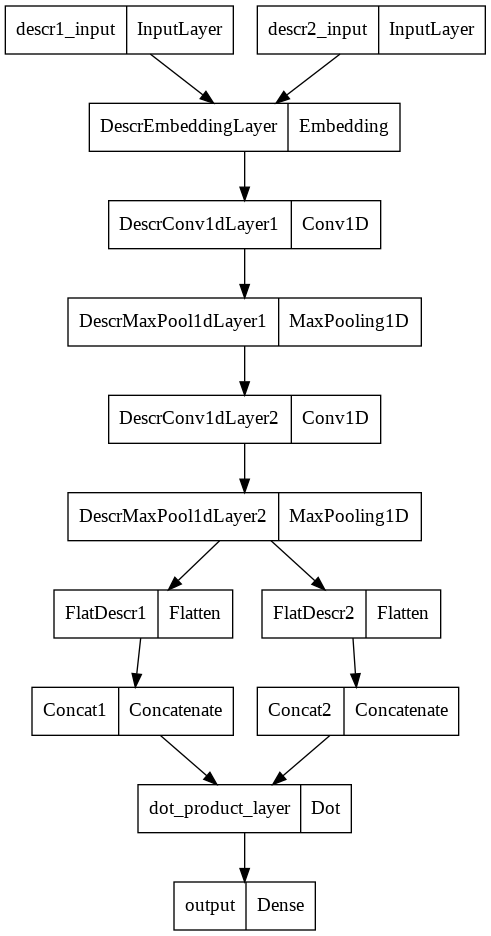

In [ ]:
def create_siamese_component(num: int):
  class SiameseComponent:
    def __init__(self, description: layers.Input, output: layers.Concatenate):
      self.description = description
      self.output = output


  descr_input = layers.Input(shape=(None,), name=f'descr{num}_input')
  descr_embedding_layer = DescrEmbeddingLayer(descr_input)
  descr_conv1d1 = DescrConv1dLayer1(descr_embedding_layer)
  descr_max_pool1d1 = DescrMaxPool1dLayer1(descr_conv1d1)
  descr_conv1d2 = DescrConv1dLayer2(descr_max_pool1d1)
  descr_max_pool1d2 = DescrMaxPool1dLayer2(descr_conv1d2)
  # descr_conv1d3 = DescrConv1dLayer3(descr_max_pool1d2)
  # descr_max_pool1d3 = DescrMaxPool1dLayer3(descr_conv1d3)
  descr_flat_Layer = layers.Flatten(name=f'FlatDescr{num}')(descr_max_pool1d2)
  
  concat = layers.Concatenate(axis=1, name=f'Concat{num}')([descr_flat_Layer])
  return SiameseComponent(title_input, descr_input, concat)


component1 = create_siamese_component(1)
component2 = create_siamese_component(2)

dot_product_layer = layers.Dot(
  axes=1,
  name='dot_product_layer'
)([component1.output, component2.output])
output = layers.Dense(
  1, activation='sigmoid', name='output',
)(dot_product_layer)
siamese_model = models.Model(
  inputs=[component1.description, component2.description],
  outputs=output,
  name='siamese_model'
)

kutils.plot_model(siamese_model)

## Train

In [ ]:
BATCH_SIZE = 2048

siamese_model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['acc'],
)
callback = callbacks.ModelCheckpoint(
    filepath=f'../../drive/MyDrive/Project 6308 + ICSME/Siamese'
             '.epoch-{epoch:02d}-loss-{val_loss:.3f}.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min',
)

In [ ]:
history = siamese_model.fit(
  generate_batches(train_df, BATCH_SIZE),
  steps_per_epoch=len(train_df) // BATCH_SIZE,
  epochs=150,
  validation_data=generate_batches(val_df, BATCH_SIZE),
  validation_steps=len(val_df) // BATCH_SIZE,
  verbose=1,
  callbacks= [callback]
)

Epoch 1/150
12/12 [==============================] - 36s 3s/step - loss: 6.6486 - acc: 0.8091 - val_loss: 0.6623 - val_acc: 0.8083
Epoch 2/150
12/12 [==============================] - 35s 3s/step - loss: 0.6533 - acc: 0.7815 - val_loss: 0.6694 - val_acc: 0.7471
Epoch 3/150
12/12 [==============================] - 34s 3s/step - loss: 0.6367 - acc: 0.7878 - val_loss: 0.6135 - val_acc: 0.8083
Epoch 4/150
12/12 [==============================] - 33s 3s/step - loss: 0.6048 - acc: 0.8090 - val_loss: 0.5952 - val_acc: 0.8083
Epoch 5/150
12/12 [==============================] - 38s 3s/step - loss: 0.5832 - acc: 0.8090 - val_loss: 0.5798 - val_acc: 0.8083
Epoch 6/150
12/12 [==============================] - 34s 3s/step - loss: 0.5667 - acc: 0.8090 - val_loss: 0.5654 - val_acc: 0.8083
Epoch 7/150
12/12 [==============================] - 33s 3s/step - loss: 0.5512 - acc: 0.8090 - val_loss: 0.5503 - val_acc: 0.8083
Epoch 8/150
12/12 [==============================] - 33s 3s/step - loss: 0.5369 - a

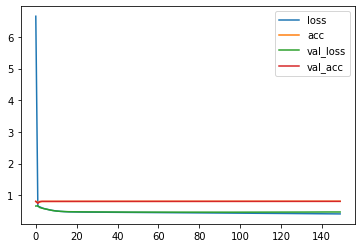

In [ ]:
ax = pd.DataFrame(history.history).plot()

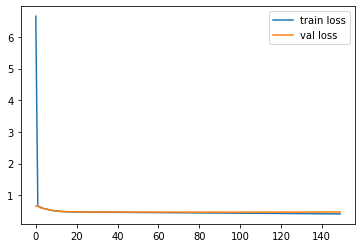

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot
import matplotlib.pyplot as plt
plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

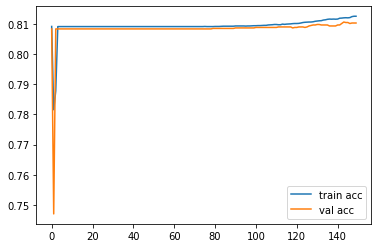

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
from sklearn.metrics import accuracy_score
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

## Evaluate on test data

In [ ]:
# from tensorflow.keras.models import load_model

# siamese_model = load_model('../../models/siamese-openOffice.epoch-30-loss-0.457.hdf5')

In [ ]:
siamese_model.evaluate(
  generate_batches(test_df, BATCH_SIZE),
  steps=len(test_df) // BATCH_SIZE,
)

3/3 [==============================] - 3s 917ms/step - loss: 0.4596 - acc: 0.8232


[0.45963379740715027, 0.8232421875]

In [ ]:
len(test_df)

8167

In [ ]:
BATCH_SIZE = len(test_df)
num_batched_instances = len(test_df) - (len(test_df) % BATCH_SIZE)
pred_y = siamese_model.predict(
  generate_batches(test_df, BATCH_SIZE),
  steps=len(test_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 5s 5s/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(
  test_df.is_similar[:num_batched_instances],
  pred_y > .5,
))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      6706
           1       0.55      0.03      0.05      1461

    accuracy                           0.82      8167
   macro avg       0.69      0.51      0.48      8167
weighted avg       0.78      0.82      0.75      8167



In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  test_df.is_similar[:num_batched_instances],
  pred_y,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.590987e+00
1,0.000149,0.000000,5.909871e-01
2,0.000298,0.000000,5.902073e-01
3,0.000298,0.002053,5.843129e-01
4,0.000596,0.002053,5.771906e-01
...,...,...,...
2385,0.999254,0.997947,3.469288e-04
2386,0.999254,0.999316,1.427829e-04
2387,0.999553,0.999316,1.018198e-05
2388,0.999553,1.000000,6.467124e-06


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  test_df.is_similar[:num_batched_instances],
  pred_y,
)

print('AUROC score:', auroc)

AUROC score: 0.647058790507668


In [ ]:
print('For probability:')
print(f'Mean: {pred_y.mean()}, STD: {pred_y.std()}')
print('For categorical:')
print(f'Mean: {(pred_y > .5).mean()}, STD: {(pred_y > .5).std()}')

For probability:
Mean: 0.2115832269191742, STD: 0.09416231513023376
For categorical:
Mean: 0.008448634749602058, STD: 0.09152734739120255


## Evaluate on textually similar data

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
sim_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_textually_similar_test_duplicates_preprocessed.csv')
sim_df

,Unnamed: 0,description1,description2,is_similar
0,0,user agent mozilla gecko firefox ...,user agent mozilla gecko buil...,1
1,1,affected versions nightly bu...,created attachment troubleshoot mode mov ...,0
2,2,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,0
3,3,created attachment ff with ellipsis menu...,created attachment screen shot at ...,1
4,4,user agent mozilla gecko firefox ...,created attachment screen shot at ...,0
...,...,...,...,...
1499,1509,user agent mozilla gecko firefox ...,let s move the library window to a tab ...,1
1500,1510,created attachment normandy events gif a...,created attachment screenshot load ...,0
1501,1511,user agent mozilla gecko firefox ...,mozilla gecko firefox id cset ...,0
1502,1512,created attachment bookmark dropdown webm ...,created attachment drop down gif affecte...,1


In [ ]:
len(sim_df)

1504

In [ ]:
## etar order change korte hoyeche
BATCH_SIZE = len(sim_df)
num_batched_instances = len(sim_df) - (len(sim_df) % BATCH_SIZE)
pred_y_sim = siamese_model.predict(
  generate_batches(sim_df, BATCH_SIZE),
  steps=len(sim_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 1s 756ms/step


In [ ]:
siamese_model.evaluate(
  generate_batches(sim_df, BATCH_SIZE),
  steps=len(sim_df) // BATCH_SIZE,
)

1/1 [==============================] - 1s 664ms/step - loss: 0.8368 - acc: 0.5180


[0.8367856740951538, 0.5179521441459656]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim > .5,
))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       757
           1       1.00      0.03      0.06       747

    accuracy                           0.52      1504
   macro avg       0.76      0.51      0.37      1504
weighted avg       0.75      0.52      0.37      1504



In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.586478
1,0.000000,0.001339,0.586478
2,0.000000,0.012048,0.542574
3,0.000000,0.017403,0.541360
4,0.000000,0.050870,0.462302
...,...,...,...
696,0.994716,0.986613,0.052437
697,0.997358,0.986613,0.048044
698,0.997358,0.989290,0.045877
699,1.000000,0.989290,0.037757


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  sim_df.is_similar[:num_batched_instances],
  pred_y_sim,
)

print('AUROC score:', auroc)


AUROC score: 0.5516332171486474


In [ ]:
print('For probability:')
print(f'Mean: {pred_y_sim.mean()}, STD: {pred_y_sim.std()}')
print('For categorical:')
print(f'Mean: {(pred_y_sim > .5).mean()}, STD: {(pred_y_sim > .5).std()}')

For probability:
Mean: 0.2650753855705261, STD: 0.08280113339424133
For categorical:
Mean: 0.014627659574468085, STD: 0.12005703290453898


## Evaluate on textually dissimilar data

In [ ]:
#importing the CSV file of the dataset from google drive into a dataframe
dissim_df=pd.read_csv('drive/MyDrive/Project 6308 + ICSME/Siamese/Firefox_siamese_textually_dissimilar_test_duplicates_preprocessed.csv')
dissim_df

,Unnamed: 0,description1,description2,is_similar
0,0,user agent mozilla gecko firefox ...,created attachment screen shot at ...,1
1,1,open the general tab in preferences scrol...,according to the design spec we would li...,1
2,2,hook up the sidebar switcher to the history ...,user agent mozilla gecko firefox ...,0
3,3,created attachment firefox profi...,created attachment screen capture wmv ste...,1
4,4,filed by wkocher at mozilla com job i...,central as beta simulation jobs repo tr...,0
...,...,...,...,...
1452,1495,created attachment troubleshooting info an...,user agent mozilla gecko firefox ...,1
1453,1496,bug was originally filed for favicons fal...,in each new window that i open the bookmark...,0
1454,1497,created attachment image png the last thi...,this bug was filed from the socorro interfac...,0
1455,1498,restylesearches is brittle to unexpected dif...,bug added the browser urlbar restylesearc...,1


In [ ]:
BATCH_SIZE = len(dissim_df)
num_batched_instances = len(dissim_df) - (len(dissim_df) % BATCH_SIZE)
pred_y_dis = siamese_model.predict(
  generate_batches(dissim_df, BATCH_SIZE),
  steps=len(dissim_df) // BATCH_SIZE,
  verbose=1,
)

1/1 [==============================] - 1s 710ms/step


In [ ]:
siamese_model.evaluate(
  generate_batches(dissim_df, BATCH_SIZE),
  steps=len(dissim_df) // BATCH_SIZE,
)

1/1 [==============================] - 1s 1s/step - loss: 0.9391 - acc: 0.5141


[0.9391145706176758, 0.5140700340270996]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis > .5,
))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       734
           1       0.94      0.02      0.04       723

    accuracy                           0.51      1457
   macro avg       0.73      0.51      0.36      1457
weighted avg       0.72      0.51      0.36      1457



In [ ]:
from sklearn.metrics import roc_curve

value_names = ['TPR', 'FPR', 'Threshold']
roc = dict(zip(value_names, roc_curve(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis,
)))
pd.DataFrame(roc)

,TPR,FPR,Threshold
0,0.000000,0.000000,1.586250
1,0.000000,0.001383,0.586250
2,0.000000,0.020747,0.507750
3,0.001362,0.020747,0.505845
4,0.001362,0.024896,0.484292
...,...,...,...
707,0.995913,0.984786,0.017326
708,0.998638,0.984786,0.013606
709,0.998638,0.990318,0.007335
710,1.000000,0.990318,0.005845


In [ ]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(
  dissim_df.is_similar[:num_batched_instances],
  pred_y_dis,
)

print('AUROC score:', auroc)


AUROC score: 0.5603958679585891


In [ ]:
print('For probability:')
print(f'Mean: {pred_y_dis.mean()}, STD: {pred_y_dis.std()}')
print('For categorical:')
print(f'Mean: {(pred_y_dis > .5).mean()}, STD: {(pred_y_dis > .5).std()}')

For probability:
Mean: 0.21821066737174988, STD: 0.09100861102342606
For categorical:
Mean: 0.011667810569663692, STD: 0.10738562644122414
